In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
# !pip install dmba
from dmba import regressionSummary
from statsmodels.tsa import tsatools

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
amtrak = pd.read_csv('Amtrak.csv')
amtrak.head()

,Month,Ridership
0,01/01/1991,1708.917
1,01/02/1991,1620.586
2,01/03/1991,1972.715
3,01/04/1991,1811.665
4,01/05/1991,1974.964


In [3]:
amtrak['date'] = pd.to_datetime(amtrak.Month,format='%d/%m/%Y')
amtrak.head()

,Month,Ridership,date
0,01/01/1991,1708.917,1991-01-01
1,01/02/1991,1620.586,1991-02-01
2,01/03/1991,1972.715,1991-03-01
3,01/04/1991,1811.665,1991-04-01
4,01/05/1991,1974.964,1991-05-01


In [4]:
ridership_df = amtrak
ridership_df.head()

,Month,Ridership,date
0,01/01/1991,1708.917,1991-01-01
1,01/02/1991,1620.586,1991-02-01
2,01/03/1991,1972.715,1991-03-01
3,01/04/1991,1811.665,1991-04-01
4,01/05/1991,1974.964,1991-05-01


In [5]:
ridership_ts = pd.Series(ridership_df.Ridership.values, index=ridership_df.date, name='ridership')

In [6]:
ridership_ts

date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
                ...   
2003-11-01    2076.054
2003-12-01    2140.677
2004-01-01    1831.508
2004-02-01    1838.006
2004-03-01    2132.446
Name: ridership, Length: 159, dtype: float64

Defined the frequency of the data

In [7]:
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index,freq=ridership_ts.index.inferred_freq)
ridership_ts

date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
                ...   
2003-11-01    2076.054
2003-12-01    2140.677
2004-01-01    1831.508
2004-02-01    1838.006
2004-03-01    2132.446
Freq: MS, Name: ridership, Length: 159, dtype: float64

PLot the data

In [8]:
ridership_ts_3yrs = ridership_ts['1997':'1999']
ridership_ts_3yrs.tail()

date
1999-08-01    1949.002
1999-09-01    1607.373
1999-10-01    1803.664
1999-11-01    1850.309
1999-12-01    1836.435
Freq: MS, Name: ridership, dtype: float64

In [9]:
ridership_df_trend = tsatools.add_trend(ridership_ts,trend='ctt')
ridership_df_trend

,ridership,const,trend,trend_squared
date,,,,
1991-01-01,1708.917,1.0,1.0,1.0
1991-02-01,1620.586,1.0,2.0,4.0
1991-03-01,1972.715,1.0,3.0,9.0
1991-04-01,1811.665,1.0,4.0,16.0
1991-05-01,1974.964,1.0,5.0,25.0
...,...,...,...,...
2003-11-01,2076.054,1.0,155.0,24025.0
2003-12-01,2140.677,1.0,156.0,24336.0
2004-01-01,1831.508,1.0,157.0,24649.0


In [10]:
ridership_lm = sm.ols('ridership ~ trend + trend_squared', data=ridership_df_trend).fit()

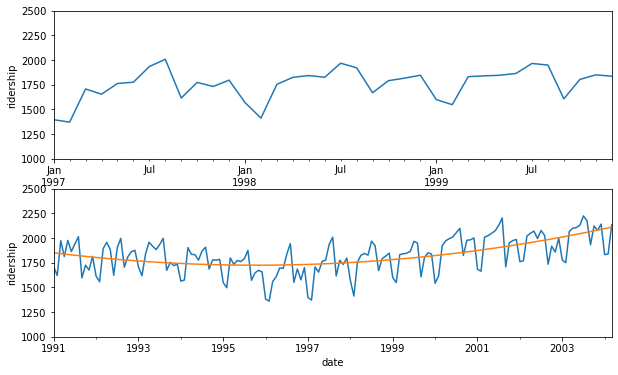

In [11]:
fig, axes = plt.subplots(2,1, figsize=(10,6))
ridership_ts_3yrs.plot(ax=axes[0])
ridership_ts.plot(ax=axes[1])
for ax in axes:
  ax.set_xlabel('time')
  ax.set_ylabel('ridership')
  ax.set_ylim(1000,2500)
ridership_lm.predict(ridership_df_trend).plot(ax=axes[1])
plt.show()

parition timeseries dataset

In [31]:
nvalid = 36
ntrain=len(ridership_ts) - nvalid
train_ts = ridership_ts[:ntrain]
valid_ts = ridership_ts[ntrain:]

In [34]:
valid_ts.head()

date
2001-04-01    2023.792
2001-05-01    2047.008
2001-06-01    2072.913
2001-07-01    2126.717
2001-08-01    2202.638
Freq: MS, Name: ridership, dtype: float64

In [36]:
naive_pred = pd.Series(train_ts[-1], index=valid_ts.index)
last_season= train_ts[-12:]
seasonal_pred = pd.Series(pd.concat([last_season]*5)[:len(valid_ts)].values,index=valid_ts.index)

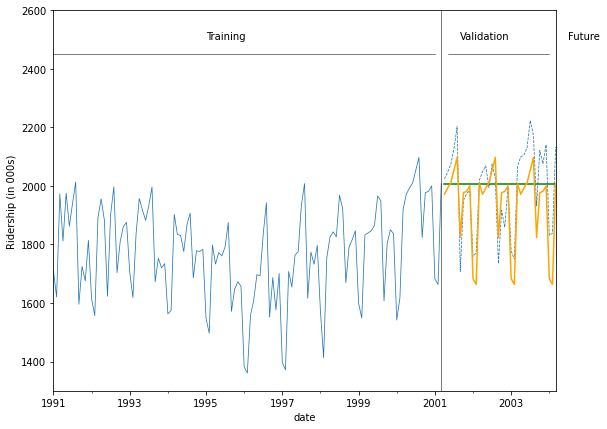

In [37]:
ax = train_ts.plot(color='C0', linewidth=0.75, figsize=(9,7))
valid_ts.plot(ax=ax, color='C0', linestyle='dashed',linewidth=0.75)
ax.set_xlim('1990', '2006-6')
ax.set_ylim(1300, 2600)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
naive_pred.plot(ax=ax, color='green')
seasonal_pred.plot(ax=ax, color='orange')
# determine coordinates for drawing the arrows and lines
one_month = pd.Timedelta('31 days')
xtrain = (min(train_ts.index), max(train_ts.index) -
one_month)
xvalid = (min(valid_ts.index) + one_month,
max(valid_ts.index) - one_month)
xfuture = (max(valid_ts.index) + one_month, '2006')
xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])
xvf = xvalid[1] + 0.5 * (xfuture[0] - xvalid[1])
ax.add_line(plt.Line2D(xtrain, (2450, 2450),
color='black', linewidth=0.5))
ax.add_line(plt.Line2D(xvalid, (2450, 2450),
color='black', linewidth=0.5))
ax.add_line(plt.Line2D(xfuture, (2450, 2450),
color='black', linewidth=0.5))
ax.text('1995', 2500, 'Training')
ax.text('2001-9', 2500, 'Validation')
ax.text('2004-7', 2500, 'Future')
ax.axvline(x=xtv, ymin=0, ymax=1, color='black',
linewidth=0.5)
ax.axvline(x=xvf, ymin=0, ymax=1, color='black',
linewidth=0.5)
plt.show()